In [13]:
# 要做雙打的位置熱度圖，我們需要把哪一隊在打球標出來
# 這樣才知道進攻站位和防守站位的差異

import pandas as pd
import sys

# load data
shots = pd.read_csv('convert_shot_double.csv')
match = pd.read_csv('match.csv', encoding='utf-8')
set = pd.read_csv('set.csv', encoding='utf-8')
rally = pd.read_csv('rally.csv', encoding='utf-8')
match = match[["match_id", "win_A", "win_B", "lose_C", "lose_D"]]
set = set[["set_id", "match_id"]]
rally = rally[["rally_id", "set_id"]]
shots = pd.merge(shots, rally, on='rally_id')
shots = pd.merge(shots, set, on='set_id')
shots = pd.merge(shots, match, on='match_id')
# drop feature
features = ["shot_id", "rally_id", "shot_num", "player", "ball_type", 
            "player_A_x", "player_A_y", "player_B_x", "player_B_y",
            "player_C_x", "player_C_y", "player_D_x", "player_D_y", 
            "win_A", "win_B", "lose_C", "lose_D"]
shots = shots[features]
print("the original columns are:")
print(shots.columns)

# extract positions in each team
shots_attack_side = pd.DataFrame()
shots_defend_side = pd.DataFrame()
rowlist_attack = []
rowlist_defend = []

# determine which player is attacking
def determine_players(row):
    if row['player'] == row['win_A']:
        hit_player_x = row['player_A_x']
        hit_player_y = row['player_A_y']
        partner_x = row['player_B_x']
        partner_y = row['player_B_y']
        defending_player1_x = row['player_C_x']
        defending_player1_y = row['player_C_y']
        defending_player2_x = row['player_D_x']
        defending_player2_y = row['player_D_y']
        attacking_team = 'A'
    elif row['player'] == row['win_B']:
        hit_player_x = row['player_B_x']
        hit_player_y = row['player_B_y']
        partner_x = row['player_A_x']
        partner_y = row['player_A_y']
        defending_player1_x = row['player_C_x']
        defending_player1_y = row['player_C_y']
        defending_player2_x = row['player_D_x']
        defending_player2_y = row['player_D_y']
        attacking_team = 'A'
    elif row['player'] == row['lose_C']:
        hit_player_x = row['player_C_x']
        hit_player_y = row['player_C_y']
        partner_x = row['player_D_x']
        partner_y = row['player_D_y']
        defending_player1_x = row['player_A_x']
        defending_player1_y = row['player_A_y']
        defending_player2_x = row['player_B_x']
        defending_player2_y = row['player_B_y']
        attacking_team = 'C'
    elif row['player'] == row['lose_D']:
        hit_player_x = row['player_D_x']
        hit_player_y = row['player_D_y']
        partner_x = row['player_C_x']
        partner_y = row['player_C_y']
        defending_player1_x = row['player_A_x']
        defending_player1_y = row['player_A_y']
        defending_player2_x = row['player_B_x']
        defending_player2_y = row['player_B_y']
        attacking_team = 'C'
    else:
        print('Error: player not found in any team')
        exit()
    return hit_player_x, hit_player_y, partner_x, partner_y, defending_player1_x, defending_player1_y, defending_player2_x, defending_player2_y, attacking_team

# iterate over each row in the shots dataframe to divide attack and defense
for _, row in shots.iterrows():
    # determine which player is attacking
    hit_player_x, hit_player_y, partner_x, partner_y, defending_player1_x, defending_player1_y, defending_player2_x, defending_player2_y, attacking_team = determine_players(row)
    
    # create a new row for team A
    new_row_A = {
        'hit_player_x': hit_player_x,
        'hit_player_y': hit_player_y,
        'partner_x': partner_x,
        'partner_y': partner_y,
        'shot_id': row['shot_id'],
        'rally_id': row['rally_id'],
        'shot_num': row['shot_num'],
        'player': row['player'],
        'ball_type': row['ball_type'],
        'attacking_team': attacking_team
    }
    
    # adjust coordinates if hit_player_y is greater than 67
    # (meaning that it is on the other side of the court)
    if new_row_A['hit_player_y'] > 67:
        new_row_A["hit_player_x"] = 61 - new_row_A["hit_player_x"]
        new_row_A["hit_player_y"] = 134 - new_row_A["hit_player_y"]
        new_row_A["partner_x"] = 61 - new_row_A["partner_x"]
        new_row_A["partner_y"] = 134 - new_row_A["partner_y"]
    # drop the row if any of the coordinates are out of bounds
    if (new_row_A['hit_player_y'] < 0 or new_row_A['partner_y'] < 0 or 
        new_row_A['hit_player_x'] < 0 or new_row_A['partner_x'] < 0 or 
        new_row_A['hit_player_y'] > 134 or new_row_A['partner_y'] > 134 or
        new_row_A['hit_player_x'] > 61 or new_row_A['partner_x'] > 61):
        pass
    else:
        rowlist_attack.append(new_row_A)
    
    # create a new row for team C
    new_row_C = {
        'player1_x': defending_player1_x,
        'player1_y': defending_player1_y,
        'player2_x': defending_player2_x,
        'player2_y': defending_player2_y,
        'shot_id': row['shot_id'],
        'rally_id': row['rally_id'],
        'shot_num': row['shot_num'],
        'player': row['player'],
        'ball_type': row['ball_type'],
    }
    # adjust coordinates if player1_y is greater than 67 
    # (meaning that it is on the other side of the court)
    if new_row_C['player1_y'] > 67:
        new_row_C["player1_x"] = 61 - new_row_C["player1_x"]
        new_row_C["player1_y"] = 134 - new_row_C["player1_y"]
        new_row_C["player2_x"] = 61 - new_row_C["player2_x"]
        new_row_C["player2_y"] = 134 - new_row_C["player2_y"]
    # drop the row if any of the coordinates are out of bounds
    if (new_row_C['player1_y'] < 0 or new_row_C['player2_y'] < 0 or 
        new_row_C['player1_x'] < 0 or new_row_C['player2_x'] < 0 or 
        new_row_C['player1_y'] > 134 or new_row_C['player2_y'] > 134 or
        new_row_C['player1_x'] > 61 or new_row_C['player2_x'] > 61):
        pass
    else: 
        rowlist_defend.append(new_row_C)
    
shots_attack_side = pd.DataFrame(rowlist_attack)
shots_defend_side = pd.DataFrame(rowlist_defend)
print("the columns after dividing attack and defense are:")
print(shots_attack_side.columns)
print(shots_defend_side.columns)


the original columns are:
Index(['shot_id', 'rally_id', 'shot_num', 'player', 'ball_type', 'player_A_x',
       'player_A_y', 'player_B_x', 'player_B_y', 'player_C_x', 'player_C_y',
       'player_D_x', 'player_D_y', 'win_A', 'win_B', 'lose_C', 'lose_D'],
      dtype='object')
the columns after dividing attack and defense are:
Index(['hit_player_x', 'hit_player_y', 'partner_x', 'partner_y', 'shot_id',
       'rally_id', 'shot_num', 'player', 'ball_type', 'attacking_team'],
      dtype='object')
Index(['player1_x', 'player1_y', 'player2_x', 'player2_y', 'shot_id',
       'rally_id', 'shot_num', 'player', 'ball_type'],
      dtype='object')


In [14]:
# this section is to drop unwanted columns and rows with NaN values

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 處理攻擊方
columns_to_check = ['hit_player_x', 'hit_player_y', 'partner_x', 'partner_y']
print("drop columns unrelated")
columns_to_drop = shots_attack_side.columns.difference(columns_to_check)
shots_attack_side = shots_attack_side.drop(columns=columns_to_drop)
print("length of data after dropping unrelated columns: ", len(drop_nan_and_unrelated_shots))
print("---------------------------------")

print("drop nan values")
shots_attack_side = shots_attack_side.dropna(subset=columns_to_check)
print("Number of NaN values in each column after dropping NaN values: ")
print(shots_attack_side.isna().sum())
print("---------------------------------")

# 處理防守方
columns_to_check = ['player1_x', 'player1_y', 'player2_x', 'player2_y']
print("drop columns unrelated")
columns_to_drop = shots_defend_side.columns.difference(columns_to_check)
shots_defend_side = shots_defend_side.drop(columns=columns_to_drop)
print("length of data after dropping unrelated columns: ", len(drop_nan_and_unrelated_shots))
print("---------------------------------")

print("drop nan values")
shots_defend_side = shots_defend_side.dropna(subset=columns_to_check)
print("Number of NaN values in each column after dropping NaN values: ")
print(shots_defend_side.isna().sum())
print("---------------------------------")

drop columns unrelated
length of data after dropping unrelated columns:  32141
---------------------------------
drop nan values
Number of NaN values in each column after dropping NaN values: 
hit_player_x    0
hit_player_y    0
partner_x       0
partner_y       0
dtype: int64
---------------------------------
drop columns unrelated
length of data after dropping unrelated columns:  32141
---------------------------------
drop nan values
Number of NaN values in each column after dropping NaN values: 
player1_x    0
player1_y    0
player2_x    0
player2_y    0
dtype: int64
---------------------------------


max hit_player_x:  58.6653538
max hit_player_y:  60.64612207
max partner_x:  60.83085145
max partner_y:  62.54775831
max player1_x:  60.75137273
max player1_y:  64.74759941
max player2_x:  60.57198813
max player2_y:  64.51397353
use heat map to show the distribution of the potision
attack player


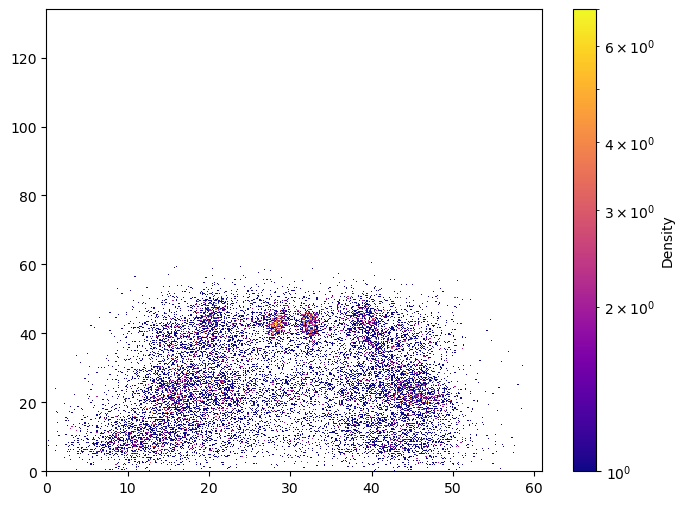

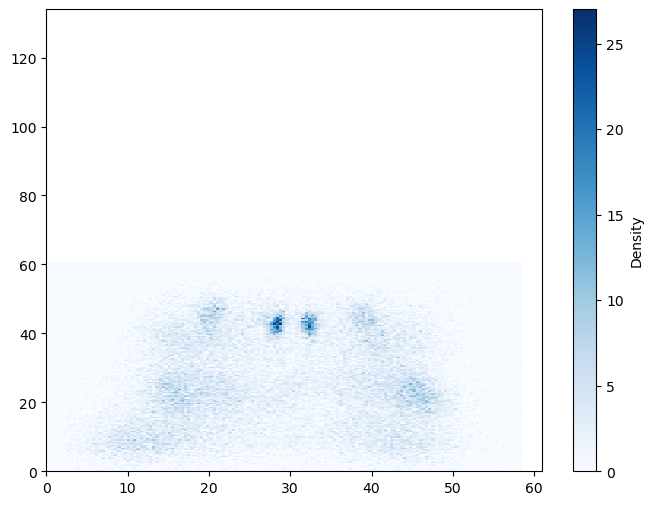

attack player's partner


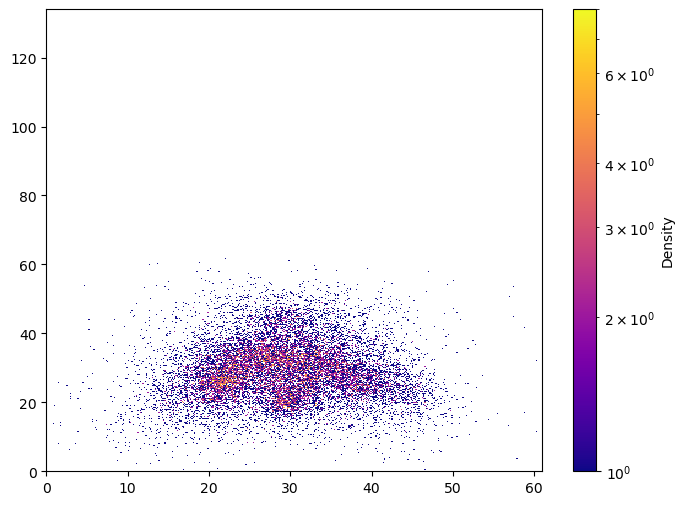

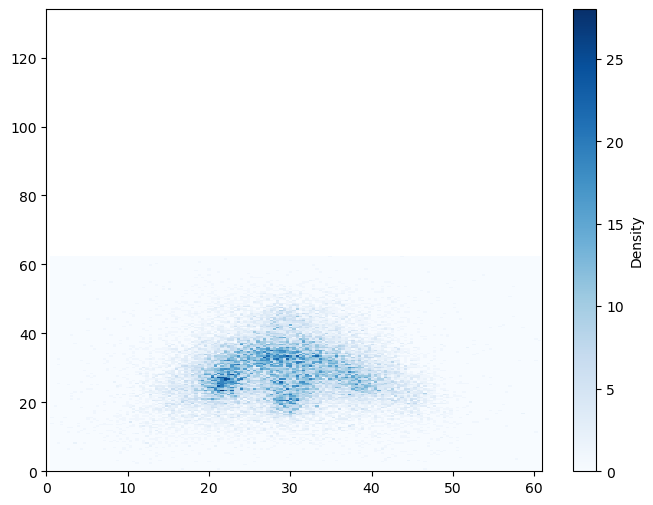

defend player


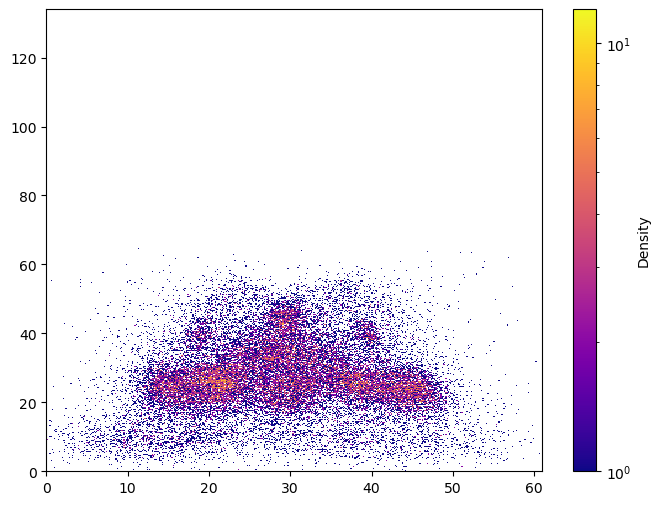

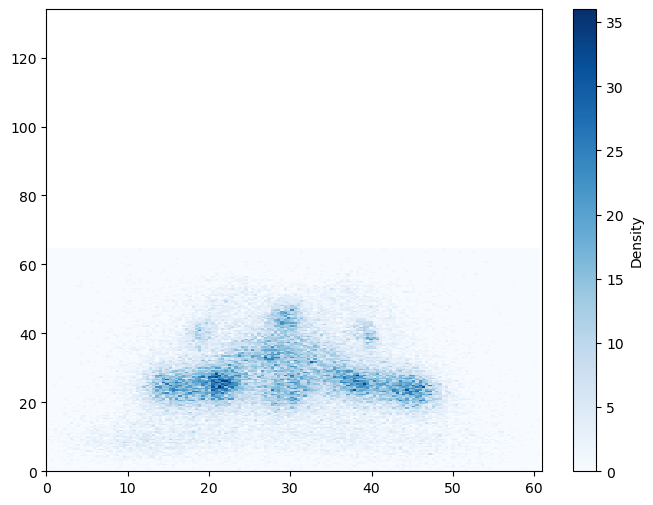

In [35]:

# drop all the number which is bigger than 134 and less than 0
from matplotlib.colors import LogNorm

print("max hit_player_x: ", shots_attack_side["hit_player_x"].max())
print("max hit_player_y: ", shots_attack_side["hit_player_y"].max())
print("max partner_x: ", shots_attack_side["partner_x"].max())
print("max partner_y: ", shots_attack_side["partner_y"].max())
print("max player1_x: ", shots_defend_side["player1_x"].max())
print("max player1_y: ", shots_defend_side["player1_y"].max())
print("max player2_x: ", shots_defend_side["player2_x"].max())
print("max player2_y: ", shots_defend_side["player2_y"].max())

# use heat map to show the distribution of the potision
print("use heat map to show the distribution of the potision")
print("attack player")
plt.figure(figsize=(8, 6))
plt.hist2d(shots_attack_side["hit_player_x"], shots_attack_side["hit_player_y"], bins=400, cmap='plasma', norm=LogNorm())
plt.colorbar(label='Density')

plt.xlim(0, 61)
plt.ylim(0, 134)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist2d(shots_attack_side["hit_player_x"], shots_attack_side["hit_player_y"], bins=150, cmap='Blues')
plt.colorbar(label='Density')

plt.xlim(0, 61)
plt.ylim(0, 134)
plt.show()

print("attack player's partner")
plt.figure(figsize=(8, 6))
plt.hist2d(shots_attack_side["partner_x"], shots_attack_side["partner_y"], bins=400, cmap='plasma', norm=LogNorm())
plt.colorbar(label='Density')

plt.xlim(0, 61)
plt.ylim(0, 134)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist2d(shots_attack_side["partner_x"], shots_attack_side["partner_y"], bins=150, cmap='Blues')
plt.colorbar(label='Density')

plt.xlim(0, 61)
plt.ylim(0, 134)
plt.show()

print("defend player")
combined_x = np.concatenate([shots_defend_side["player1_x"], shots_defend_side["player2_x"]])
combined_y = np.concatenate([shots_defend_side["player1_y"], shots_defend_side["player2_y"]])

plt.figure(figsize=(8, 6))
plt.hist2d(combined_x, combined_y, bins=400, cmap='plasma', norm=LogNorm())
plt.colorbar(label='Density')

plt.xlim(0, 61)
plt.ylim(0, 134)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist2d(combined_x, combined_y, bins=150, cmap='Blues')
plt.colorbar(label='Density')

plt.xlim(0, 61)
plt.ylim(0, 134)
plt.show()